# **Практическая работа №8. Линейная и логистическая регрессия**

## **Линейная регрессия**


###  **Задание №1. Прогнозирование продаж автомобилей**:


   - **Шаг 1**: Загрузите набор данных о продажах автомобилей, содержащий информацию о цене, возрасте, пробеге и других характеристиках.
     - **Совет**: Проверьте данные на наличие пропущенных значений и выбросов. Используйте `pandas` для обнаружения пропусков (`df.isnull().sum()`) и выбросов (например, с помощью метода межквартильного размаха - `df.boxplot()`).
     - **Совет**: Для пропущенных значений используйте стратегию заполнения средними значениями или медианой, чтобы минимизировать влияние на распределение данных (`df.fillna()`).

- Ссылка на набор данных: https://www.kaggle.com/datasets/gagandeep16/car-sales

In [19]:
import kagglehub

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/data_mining/car-sales/Car_sales.csv')

df.head()

,Manufacturer,Model,Sales_in_thousands,__year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
0,Acura,Integra,16.919,16.360,Passenger,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2/2/2012,58.280150
1,Acura,TL,39.384,19.875,Passenger,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,6/3/2011,91.370778
2,Acura,CL,14.114,18.225,Passenger,NaN,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,1/4/2012,NaN
3,Acura,RL,8.588,29.725,Passenger,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,3/10/2011,91.389779
4,Audi,A4,20.397,22.255,Passenger,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,10/8/2011,62.777639


In [4]:
print(df.isnull().sum())

Manufacturer            0
Model                   0
Sales_in_thousands      0
__year_resale_value    36
Vehicle_type            0
Price_in_thousands      2
Engine_size             1
Horsepower              1
Wheelbase               1
Width                   1
Length                  1
Curb_weight             2
Fuel_capacity           1
Fuel_efficiency         3
Latest_Launch           0
Power_perf_factor       2
dtype: int64


<Axes: >

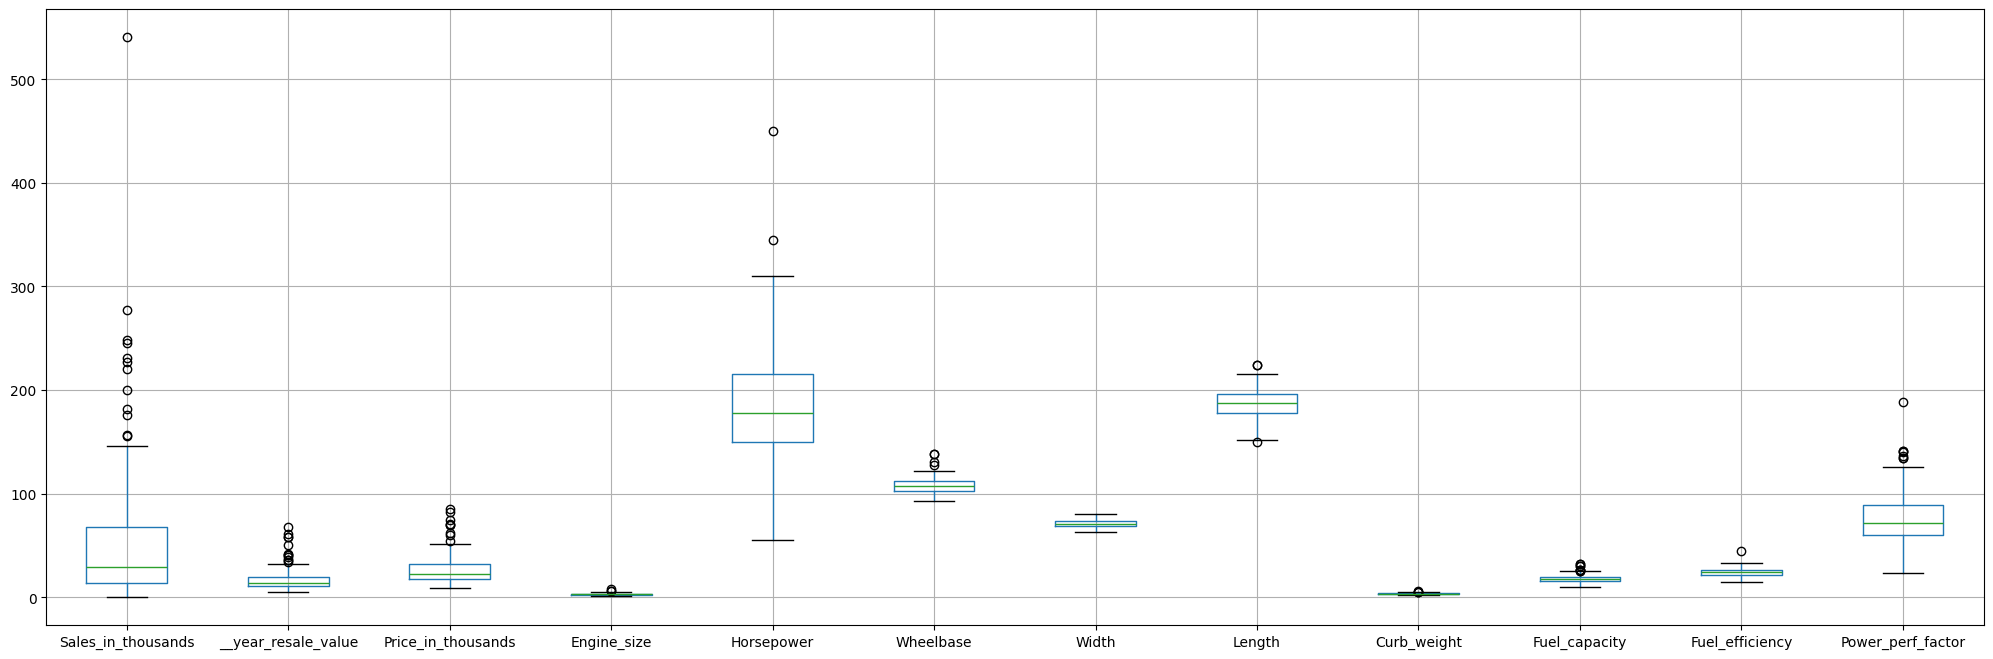

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25, 8))
df.boxplot()

In [6]:
# Список столбцов для заполнения пропусков
columns_to_fill = {
    '__year_resale_value': df['__year_resale_value'].mean(),  # или median(), если предпочтительнее
    'Price_in_thousands': df['Price_in_thousands'].median(),
    'Engine_size': df['Engine_size'].median(),
    'Horsepower': df['Horsepower'].median(),
    'Wheelbase': df['Wheelbase'].median(),
    'Width': df['Width'].median(),
    'Length': df['Length'].median(),
    'Curb_weight': df['Curb_weight'].median(),
    'Fuel_capacity': df['Fuel_capacity'].median(),
    'Fuel_efficiency': df['Fuel_efficiency'].median(),
    'Power_perf_factor': df['Power_perf_factor'].median()
}

# Заменить пропущенные значения
for column, value in columns_to_fill.items():
    df[column] = df[column].fillna(value)

print(df.isnull().sum())

Manufacturer           0
Model                  0
Sales_in_thousands     0
__year_resale_value    0
Vehicle_type           0
Price_in_thousands     0
Engine_size            0
Horsepower             0
Wheelbase              0
Width                  0
Length                 0
Curb_weight            0
Fuel_capacity          0
Fuel_efficiency        0
Latest_Launch          0
Power_perf_factor      0
dtype: int64


   - **Шаг 2**: Проведите предварительный анализ данных:
     - Постройте гистограммы для каждого числового признака, чтобы понять их распределение.
     - Постройте диаграммы рассеяния для выявления зависимостей между признаками и целевой переменной (ценой).
     - **Совет**: Используйте корреляционную матрицу для выявления сильных линейных зависимостей между признаками.

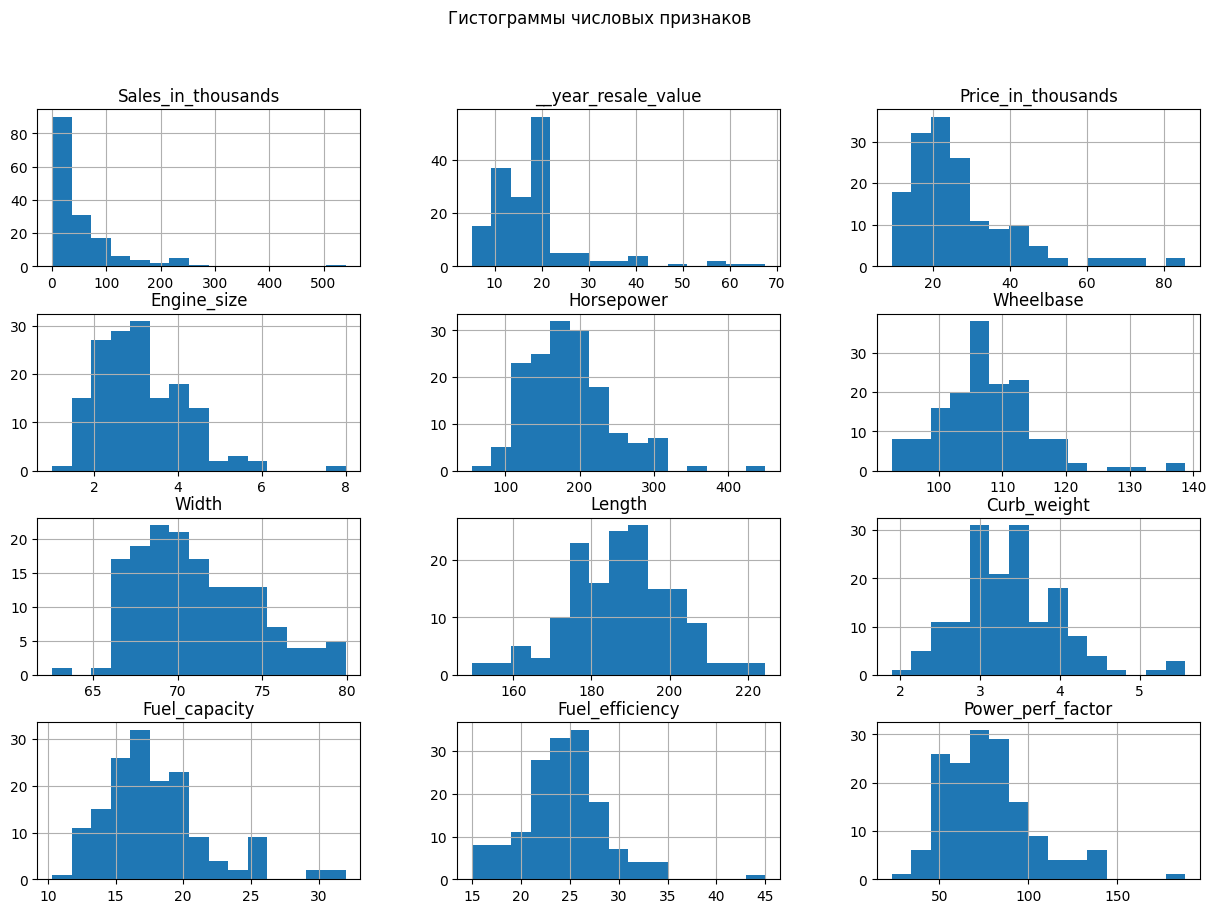

In [7]:
# Построение гистограмм для каждого числового признака
df.hist(bins=15, figsize=(15, 10))
plt.suptitle('Гистограммы числовых признаков')
plt.show()

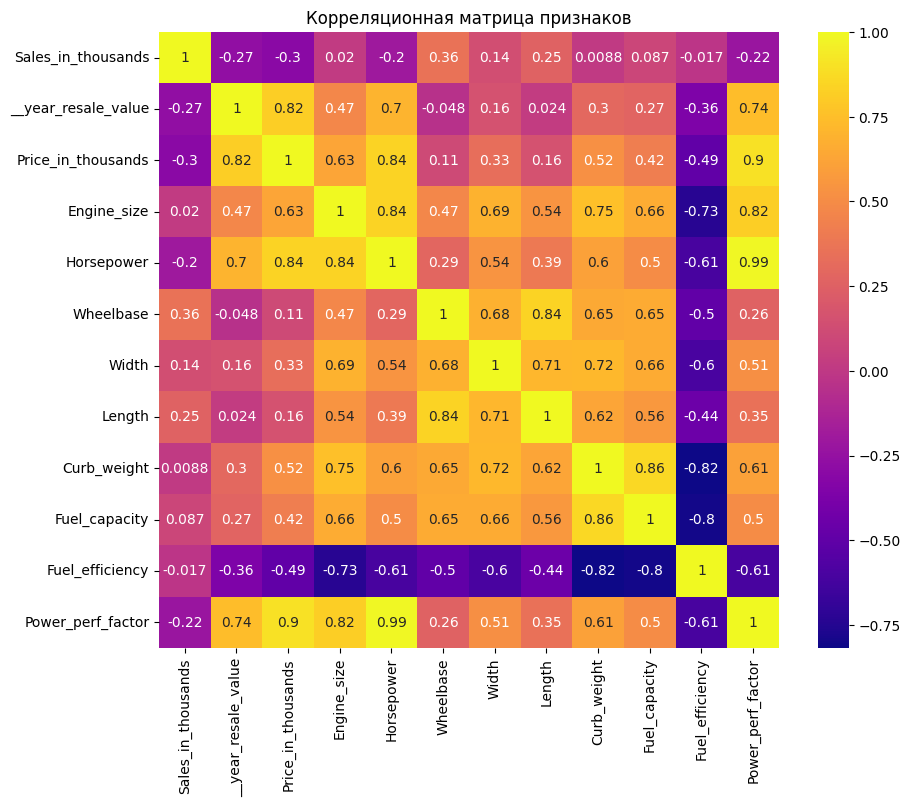

In [8]:
# Построение корреляционной матрицы
df_new = df.drop(columns=['Manufacturer',	'Model', 'Vehicle_type', 'Latest_Launch'])
corr = df_new.corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='plasma')
plt.title('Корреляционная матрица признаков')
plt.show()

   - **Шаг 3**: Разделите данные на обучающую и тестовую выборки (например, 70% на обучение и 30% на тестирование) с помощью `train_test_split` из `sklearn.model_selection`.

In [9]:
X = df.drop('Price_in_thousands', axis=1)
y = df['Price_in_thousands']

X['Launch_Year'] = pd.to_datetime(X['Latest_Launch']).dt.year
X = X.drop('Latest_Launch', axis=1)

X = pd.get_dummies(X, columns=['Manufacturer', 'Model', 'Vehicle_type'], drop_first=True)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

   - **Шаг 4**: Постройте модель линейной регрессии для предсказания цены автомобиля.
     - Используйте библиотеку `scikit-learn` для создания и обучения модели с помощью `LinearRegression`.

In [11]:
model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

   - **Шаг 5**: Оцените качество модели с использованием метрик MSE и R².
     - Выведите значения метрик и интерпретируйте их. Обратите внимание на то, насколько хорошо ваша модель предсказывает цены.

In [12]:
y_pred = model.predict(X_test)

In [13]:
# MSE и RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# R^2
r2 = r2_score(y_test, y_pred)

# Вывод метрик
print(f"Среднеквадратическая ошибка (MSE): {mse:.4f}")
print(f"Корень из MSE (RMSE): {rmse:.4f}")
print(f"Коэффициент детерминации (R^2): {r2:.4f}")

Среднеквадратическая ошибка (MSE): 4.7682
Корень из MSE (RMSE): 2.1836
Коэффициент детерминации (R^2): 0.9800


   - **Шаг 6**: Визуализируйте результаты:
     - Постройте график зависимости предсказанных цен от фактических.

In [14]:
results = pd.DataFrame({
    'Real': y_test.values,
    'Predicted': y_pred
})

results_sorted = results.sort_index()

display(results_sorted.head(10))

,Real,Predicted
0,22.195,25.175386
1,42.000,40.684071
2,19.460,23.407906
3,16.480,15.458150
4,31.505,35.033402
5,21.410,20.558951
6,13.960,13.629721
7,62.000,59.862513
8,18.575,21.023568
9,21.620,22.865758


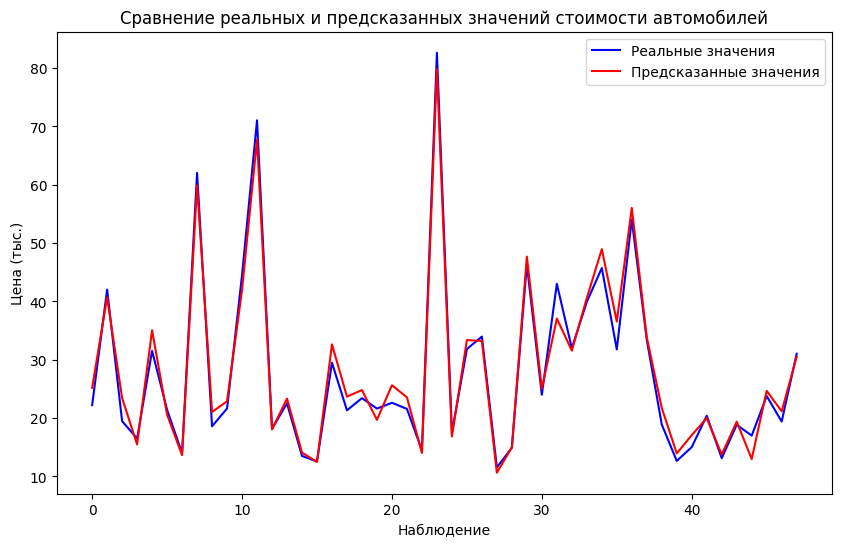

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(results_sorted['Real'].values, label='Реальные значения', color='blue')
plt.plot(results_sorted['Predicted'].values, label='Предсказанные значения', color='red')
plt.legend()
plt.title('Сравнение реальных и предсказанных значений стоимости автомобилей')
plt.xlabel('Наблюдение')
plt.ylabel('Цена (тыс.)')
plt.show()


### **Задание №2. Влияние погодных условий на урожайность**:


   - **Шаг 1**: Загрузите набор данных о погодных условиях и урожайности сельскохозяйственных культур.
     - **Совет**: Проверьте данные на наличие пропущенных значений и выбросов. Используйте стратегию заполнения пропусков средними значениями или медианой.

- Ссылка на набор данных: https://www.kaggle.com/datasets/waqi786/climate-change-impact-on-agriculture

In [16]:
df_2 = pd.read_csv('/content/drive/MyDrive/data_mining/agro/climate_change_impact_on_agriculture_2024.csv')
df_2.head()

,Year,Country,Region,Crop_Type,Average_Temperature_C,Total_Precipitation_mm,CO2_Emissions_MT,Crop_Yield_MT_per_HA,Extreme_Weather_Events,Irrigation_Access_%,Pesticide_Use_KG_per_HA,Fertilizer_Use_KG_per_HA,Soil_Health_Index,Adaptation_Strategies,Economic_Impact_Million_USD
0,2001,India,West Bengal,Corn,1.55,447.06,15.22,1.737,8,14.54,10.08,14.78,83.25,Water Management,808.13
1,2024,China,North,Corn,3.23,2913.57,29.82,1.737,8,11.05,33.06,23.25,54.02,Crop Rotation,616.22
2,2001,France,Ile-de-France,Wheat,21.11,1301.74,25.75,1.719,5,84.42,27.41,65.53,67.78,Water Management,796.96
3,2001,Canada,Prairies,Coffee,27.85,1154.36,13.91,3.890,5,94.06,14.38,87.58,91.39,No Adaptation,790.32
4,1998,India,Tamil Nadu,Sugarcane,2.19,1627.48,11.81,1.080,9,95.75,44.35,88.08,49.61,Crop Rotation,401.72


In [17]:
print(df_2.isnull().sum())

Year                           0
Country                        0
Region                         0
Crop_Type                      0
Average_Temperature_C          0
Total_Precipitation_mm         0
CO2_Emissions_MT               0
Crop_Yield_MT_per_HA           0
Extreme_Weather_Events         0
Irrigation_Access_%            0
Pesticide_Use_KG_per_HA        0
Fertilizer_Use_KG_per_HA       0
Soil_Health_Index              0
Adaptation_Strategies          0
Economic_Impact_Million_USD    0
dtype: int64


<Axes: >

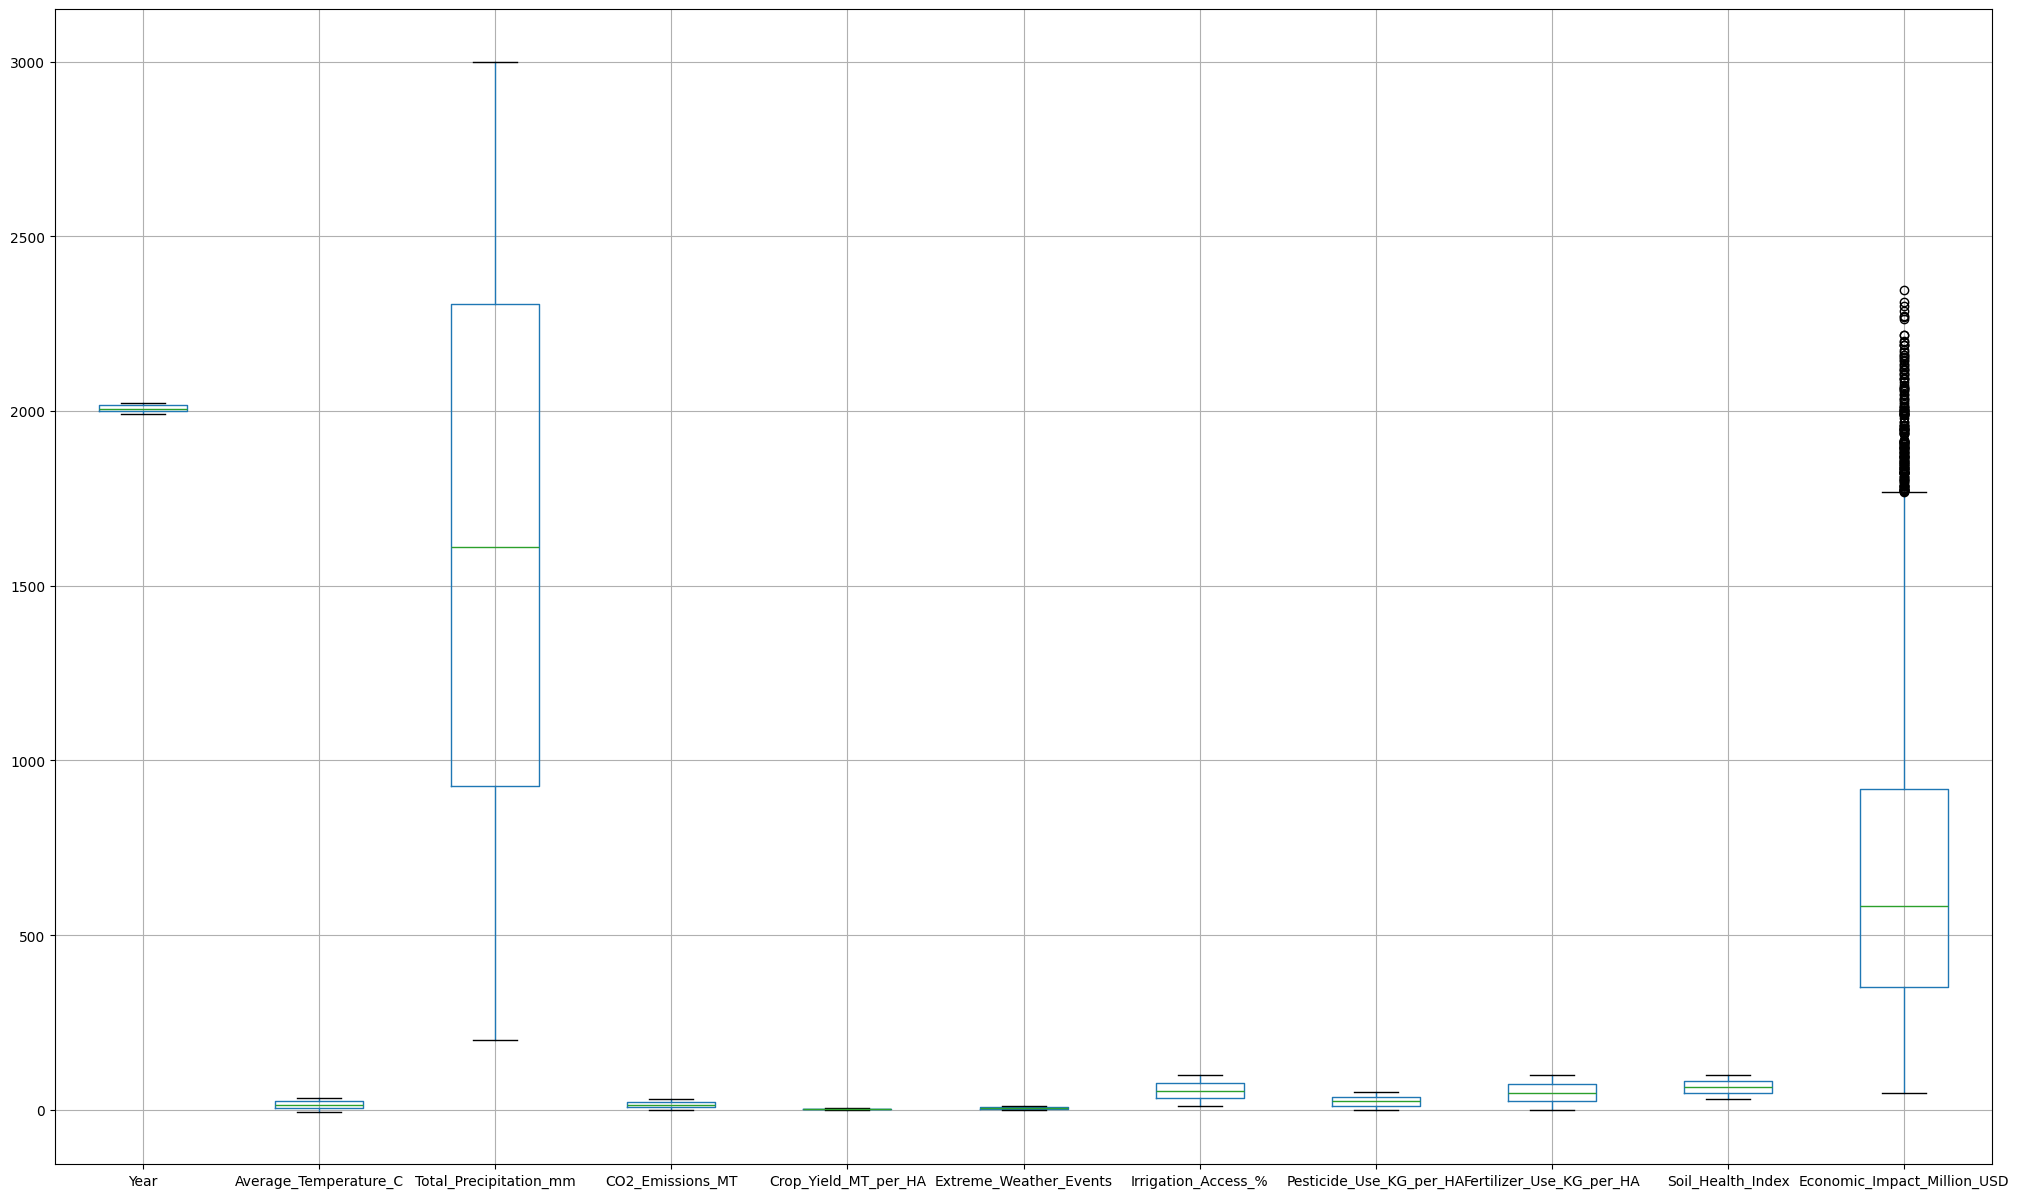

In [18]:
plt.figure(figsize=(25, 15))
df_2.boxplot()

   - **Шаг 2**: Выполните анализ данных:
     - Постройте корреляционную матрицу для выявления зависимостей между признаками.
     - Постройте диаграммы рассеяния для ключевых признаков.
     - **Совет**: Удалите или преобразуйте признаки с низкой корреляцией с целевой переменной, чтобы улучшить модель.

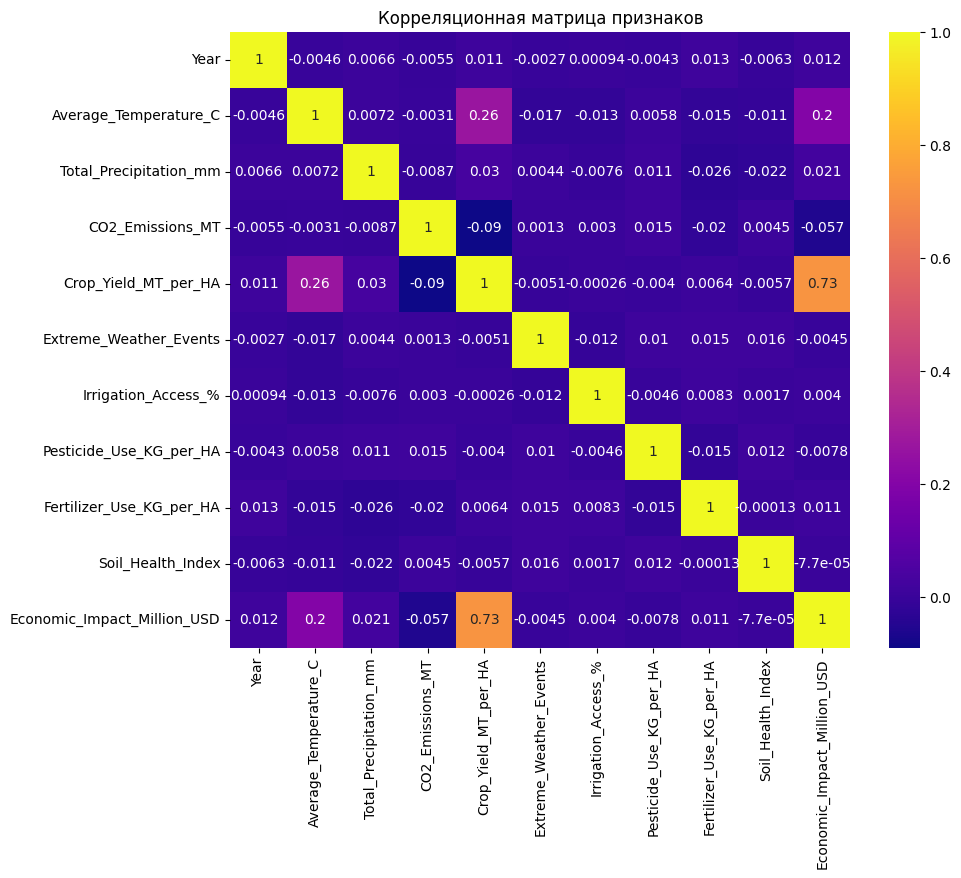

In [19]:
df_new_2 = df_2.drop(columns=['Country', 'Region', 'Crop_Type', 'Adaptation_Strategies'])
corr_2 = df_new_2.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_2, annot=True, cmap='plasma')
plt.title('Корреляционная матрица признаков')
plt.show()

In [20]:
key_features = ['Average_Temperature_C', 'Total_Precipitation_mm', 'Extreme_Weather_Events']
target = 'Crop_Yield_MT_per_HA'

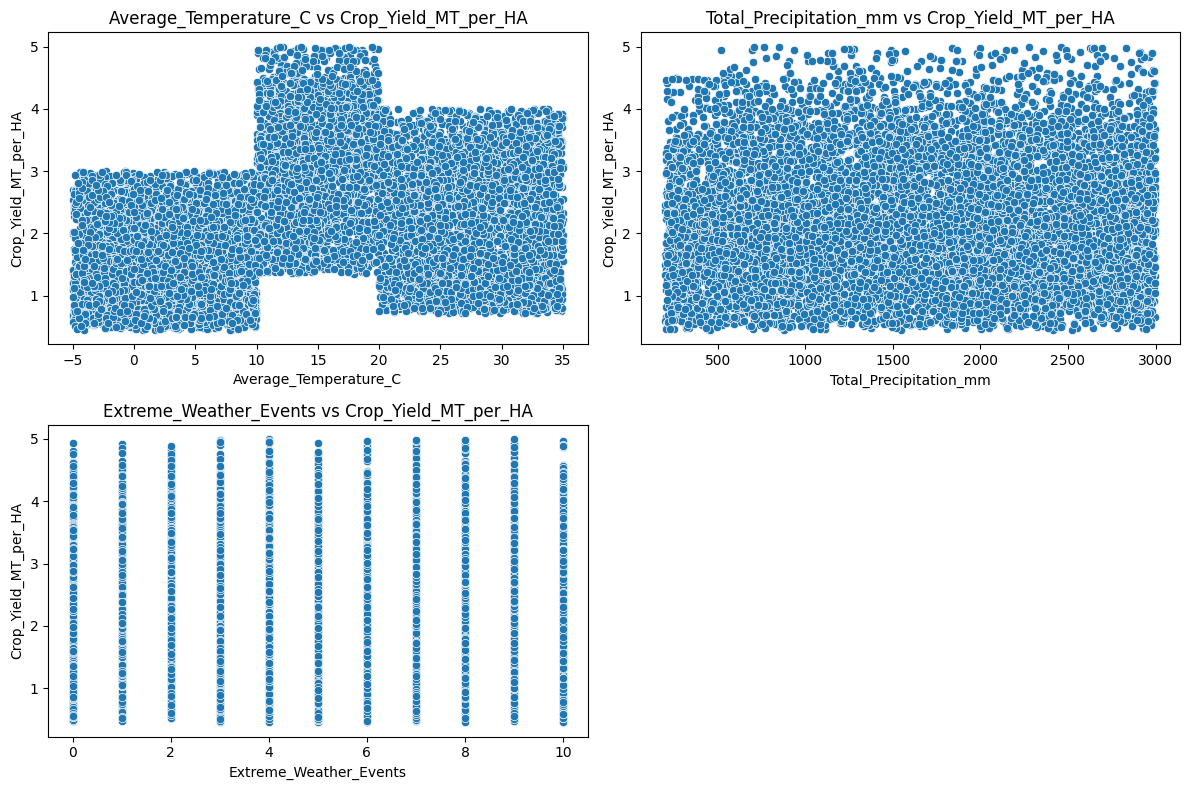

In [21]:
plt.figure(figsize=(12, 8))
for i, feature in enumerate(key_features):
    plt.subplot(2, 2, i + 1)  # 2 строки, 2 столбца
    sns.scatterplot(data=df_2, x=feature, y=target)
    plt.title(f'{feature} vs {target}')
    plt.xlabel(feature)
    plt.ylabel(target)

plt.tight_layout()
plt.show()

   - **Шаг 3**: Разделите данные на обучающую и тестовую выборки.

In [22]:
X = df_2[['Average_Temperature_C', 'Total_Precipitation_mm']]
y = df_2['Crop_Yield_MT_per_HA']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

   - **Шаг 4**: Постройте модель линейной регрессии для оценки влияния температуры и уровня осадков на урожайность.
     - Используйте библиотеку `scikit-learn` для создания и обучения модели.

In [23]:
model_2 = LinearRegression()
model_2.fit(X_train, y_train)

LinearRegression()

   - **Шаг 5**: Проведите оценку точности модели.
     - Выведите значения метрик MSE и R² и интерпретируйте их.

In [24]:
y_pred = model_2.predict(X_test)

mse_2 = mean_squared_error(y_test, y_pred)
rmse_2 = np.sqrt(mse_2)

r2_2 = r2_score(y_test, y_pred)

print(f"Среднеквадратическая ошибка (MSE): {mse_2:.4f}")
print(f"Корень из MSE (RMSE): {rmse_2:.4f}")
print(f"Коэффициент детерминации (R^2): {r2_2:.4f}")

Среднеквадратическая ошибка (MSE): 0.9275
Корень из MSE (RMSE): 0.9631
Коэффициент детерминации (R^2): 0.0720


   - **Шаг 6**: Визуализируйте данные и результаты модели:
     - Постройте график зависимости предсказанных значений от фактических.

In [25]:
results_2 = pd.DataFrame({
    'Real': y_test.values,
    'Predicted': y_pred
})
display(results_2.head(10))

,Real,Predicted
0,3.300,2.419635
1,1.629,1.967562
2,3.429,2.559087
3,2.100,2.379055
4,2.520,2.559862
5,1.512,2.683935
6,1.944,2.283195
7,2.700,2.105054
8,1.540,1.971703
9,0.864,2.647503


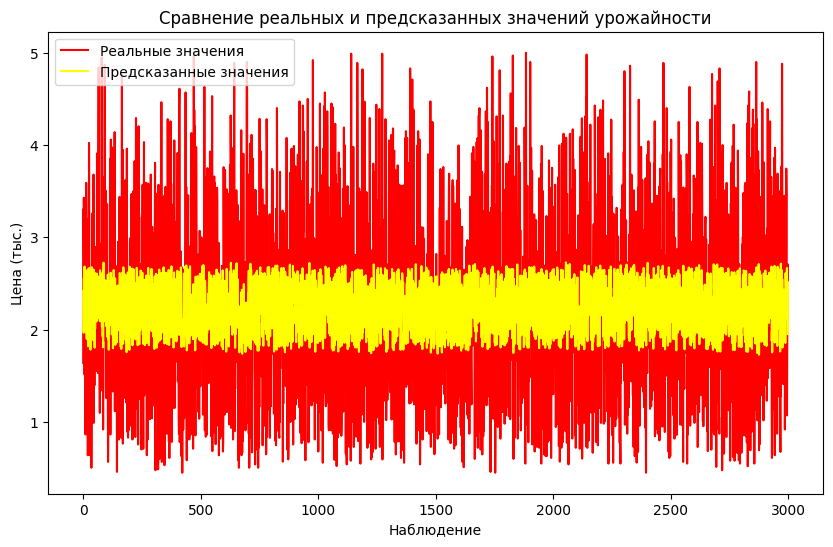

In [26]:
results_sorted_2 = results_2.sort_index()

plt.figure(figsize=(10, 6))
plt.plot(results_sorted_2['Real'].values, label='Реальные значения', color='red')
plt.plot(results_sorted_2['Predicted'].values, label='Предсказанные значения', color='yellow')
plt.legend()
plt.title('Сравнение реальных и предсказанных значений урожайности')
plt.xlabel('Наблюдение')
plt.ylabel('Цена (тыс.)')
plt.show()

## **Логистическая регрессия**


### **Задание №3. Классификация клиентов банка**:


   - **Шаг 1**: Загрузите набор данных о клиентах банка, включающий данные о возрасте, доходе, кредитной истории и других характеристиках.
     - **Совет**: Проверьте данные на наличие пропущенных значений и выбросов. Используйте стратегию заполнения пропусков средними значениями или медианой.

- Ссылка на набор данных: https://www.kaggle.com/datasets/henriqueyamahata/bank-marketing/data

In [27]:
df_3 = pd.read_csv('/content/drive/MyDrive/data_mining/bank/bank-additional-full.csv', sep = ";")
df_3.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


   - **Шаг 2**: Проведите анализ данных и предобработку:
     - Закодируйте категориальные переменные с помощью `OneHotEncoder` или `pd.get_dummies`.
     - Нормализуйте числовые признаки с помощью `StandardScaler` для улучшения обучения модели.
     - **Совет**: Убедитесь, что все признаки имеют одинаковый масштаб, чтобы избежать доминирования одного признака над другими.

In [28]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [29]:
df_3_new = pd.get_dummies(df_3, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y'], drop_first=True)

In [30]:
df_3_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   duration                       41188 non-null  int64  
 2   campaign                       41188 non-null  int64  
 3   pdays                          41188 non-null  int64  
 4   previous                       41188 non-null  int64  
 5   emp.var.rate                   41188 non-null  float64
 6   cons.price.idx                 41188 non-null  float64
 7   cons.conf.idx                  41188 non-null  float64
 8   euribor3m                      41188 non-null  float64
 9   nr.employed                    41188 non-null  float64
 10  job_blue-collar                41188 non-null  bool   
 11  job_entrepreneur               41188 non-null  bool   
 12  job_housemaid                  41188 non-null 

In [31]:
X = df_3_new.drop('y_yes', axis=1)
y = df_3_new['y_yes']

In [32]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

   - **Шаг 3**: Разделите данные на обучающую и тестовую выборки.


In [33]:
X = pd.DataFrame(X_scaled, columns=X.columns)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

   - **Шаг 4**: Постройте модель логистической регрессии для предсказания вероятности открытия депозитного счета клиентом.
     - Используйте библиотеку `scikit-learn` для создания и обучения модели с помощью `LogisticRegression`.

In [35]:
model_3 = LogisticRegression()
model_3.fit(X_train, y_train)

LogisticRegression()

   - **Шаг 5**: Оцените качество модели с использованием метрик точности, полноты и F1-меры.
     - Выведите значения метрик и интерпретируйте их. Обратите внимание на баланс между точностью и полнотой.
    - Постройте матрицу ошибок с помощью `confusion_matrix` и визуализируйте ее с помощью `seaborn.heatmap`.

In [36]:
y_pred = model_3.predict(X_test)

In [37]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")

print(f"Точность: {accuracy:.4f}")
print(f"Полнота: {recall:.4f}")
print(f"F1-мера: {f1:.4f}")

Точность: 0.9101
Полнота: 0.6990
F1-мера: 0.7350


Text(0.5, 1.0, 'Матрица ошибок')

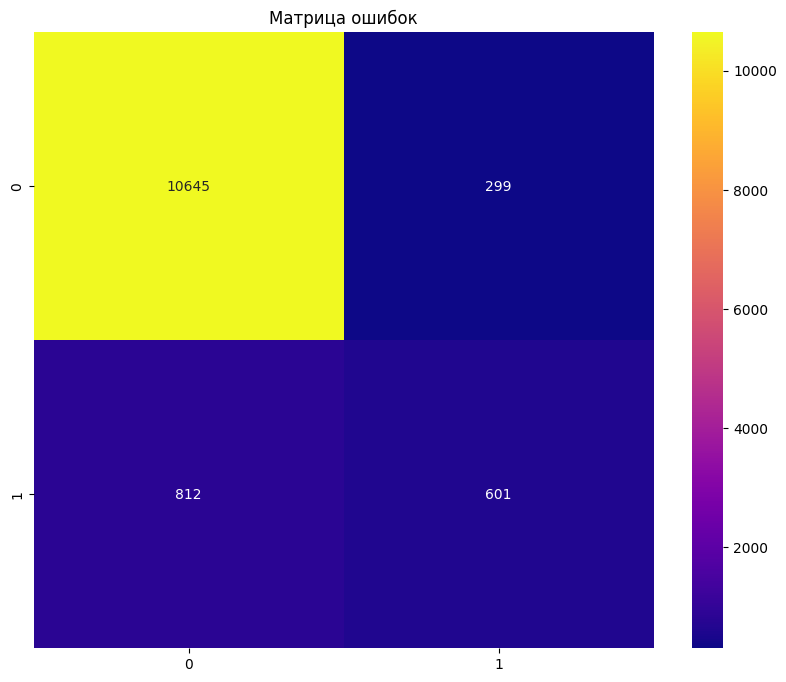

In [38]:
conf_mat=confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='plasma')
plt.title('Матрица ошибок')



   

   
   

   

   
   - **Шаг 6**: Визуализируйте ROC-кривую и вычислите AUC для оценки модели.
     - Используйте `roc_curve` и `auc` из `sklearn.metrics` для построения и расчета.

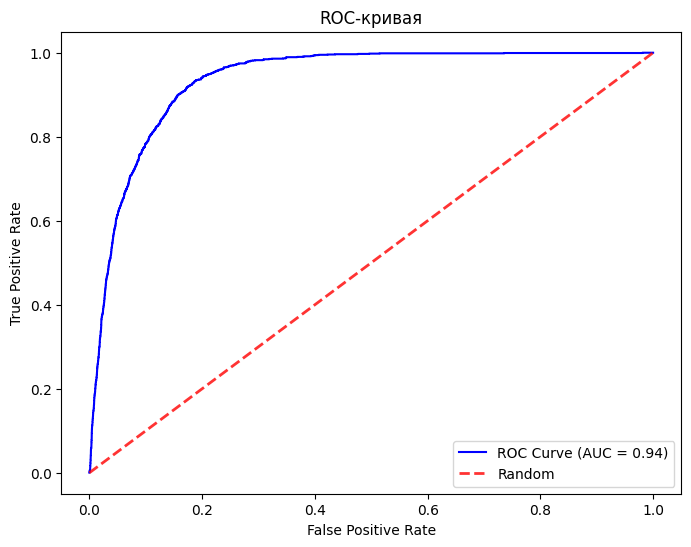

In [39]:
y_pred_proba = model_3.predict_proba(X_test)[:, 1]  # Вероятности для класса '1'

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='red', label='Random', alpha=0.8)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.legend()
plt.show()

### **Задание №4. Распознавание спама**:


   - **Шаг 1**: Загрузите набор данных с текстами электронных писем, маркированных как "спам" или "не спам".
     - **Совет**: Проверьте данные на наличие пропущенных значений и оцените, какие признаки могут быть важными для классификации.

- Ссылка на набор данных: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

In [3]:
df_4 = pd.read_csv('/content/drive/MyDrive/data_mining/spam/spam.csv', encoding='latin1')
df_4.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


   - **Шаг 2**: Выполните предварительную обработку текстов:
     - Выполните токенизацию и векторизацию с помощью `Word2Vec` или `Doc2Vec`.

In [4]:
df_4 = df_4.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

In [5]:
import gensim

In [7]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Токенизация документов
documents = [TaggedDocument(words=row.split(), tags=[i]) for i, row in enumerate(df_4['v2'])]
# Обучение модели Doc2Vec
model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, epochs=100)
# Получение векторов документов
X = [model.infer_vector(doc.words) for doc in documents]
y = df_4['v1']

   - **Шаг 3**: Разделите данные на обучающую и тестовую выборки.

In [9]:
from sklearn.preprocessing import LabelEncoder

In [10]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

   - **Шаг 4**: Постройте модель логистической регрессии для классификации писем на спам и не спам.
     - Используйте библиотеку `scikit-learn` для создания и обучения модели с помощью `LogisticRegression`.
     - Сравните результаты с моделью `MultinomialNB` *(Наивного Байеса)*

In [12]:
l_model = LogisticRegression()
l_model.fit(X_train, y_train)

LogisticRegression()

In [15]:
df_4_nb = pd.read_csv('/content/drive/MyDrive/data_mining/spam/spam.csv', encoding='latin1')
df_4_nb = df_4_nb.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
X_nb = df_4_nb['v2']  # Матрица признаков
y_nb = df_4_nb['v1']               # Целевая переменная
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_nb = label_encoder.fit_transform(y_nb)
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(X_nb, y_nb,
                                                    test_size=0.3,
                                                    random_state=1)

In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vectorizer_tfidf', TfidfVectorizer()),   # Преобразование текста в числовые признаки
    ('classifier', MultinomialNB())  # Мультиномиальный наивный байесовский классификатор
])
pipeline.fit(X_train_nb, y_train_nb)

Pipeline(steps=[('vectorizer_tfidf', TfidfVectorizer()),
                ('classifier', MultinomialNB())])

In [17]:
y_pred_log = l_model.predict(X_test)
log_acc=accuracy_score(y_test,y_pred_log)
y_pred_nb = pipeline.predict(X_test_nb)
naive_acc=accuracy_score(y_test_nb,y_pred_nb)

print("Точность модели логистической регрессии:", log_acc)
print("Точность модели Наивного Байеса:", naive_acc)

Точность модели логистической регрессии: 0.9455741626794258
Точность модели Наивного Байеса: 0.9611244019138756


   - **Шаг 5**: Оцените качество моделей с помощью матрицы ошибок и ROC-кривой.
     - Постройте матрицу ошибок с помощью `confusion_matrix` и визуализируйте ее с помощью `seaborn.heatmap`.
     - Постройте ROC-кривую и вычислите AUC.

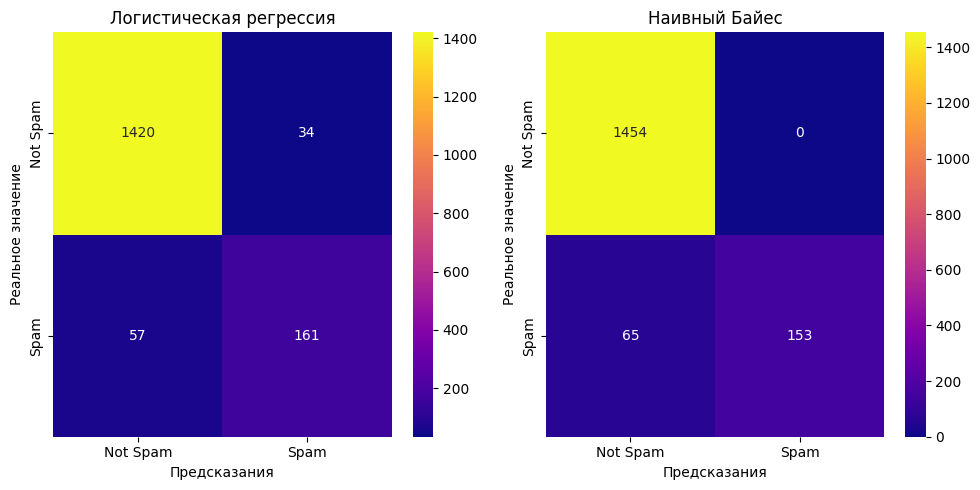

In [21]:
confusion_log = confusion_matrix(y_test, y_pred_log)
confusion_nb = confusion_matrix(y_test_nb, y_pred_nb)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_log, annot=True, fmt='d', cmap='plasma', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.title('Логистическая регрессия')
plt.xlabel('Предсказания')
plt.ylabel('Реальное значение')

plt.subplot(1, 2, 2)
sns.heatmap(confusion_nb, annot=True, fmt='d', cmap='plasma', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.title('Наивный Байес')
plt.xlabel('Предсказания')
plt.ylabel('Реальное значение')

plt.tight_layout()
plt.show()

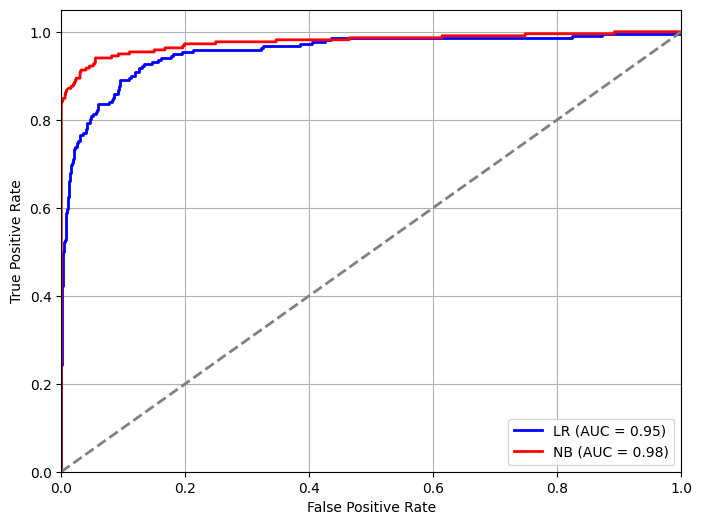

In [22]:
label_encoder = LabelEncoder()
y_nb_encoded = label_encoder.fit_transform(y_nb)
y_pred_proba_log = l_model.predict_proba(X_test)[:, 1]
y_pred_proba_nb = pipeline.predict_proba(X_test_nb)[:, 1]
# ROC-кривая и AUC для LR
fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_proba_log)
roc_auc_log = auc(fpr_log, tpr_log)

# ROC-кривая и AUC для NB
fpr_nb, tpr_nb, _ = roc_curve(y_test_nb, y_pred_proba_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

# Визуализация ROC-кривых
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, color='blue', lw=2, label='LR (AUC = %0.2f)' % roc_auc_log)
plt.plot(fpr_nb, tpr_nb, color='red', lw=2, label='NB (AUC = %0.2f)' % roc_auc_nb)
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

   - **Шаг 6**: Визуализируйте результаты классификации и сравните их с исходными метками.
     - Приведите примеры писем, которые были неправильно классифицированы, и напишите возможные причины ошибок.

In [23]:
# Создание DataFrame с реальными и предсказанными значениями
results_log = pd.DataFrame({
    'Real': y_test,
    'Predicted': y_pred_log
})

# Отображение первых 10 значений
display(results_log.head(10))

,Real,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,1,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


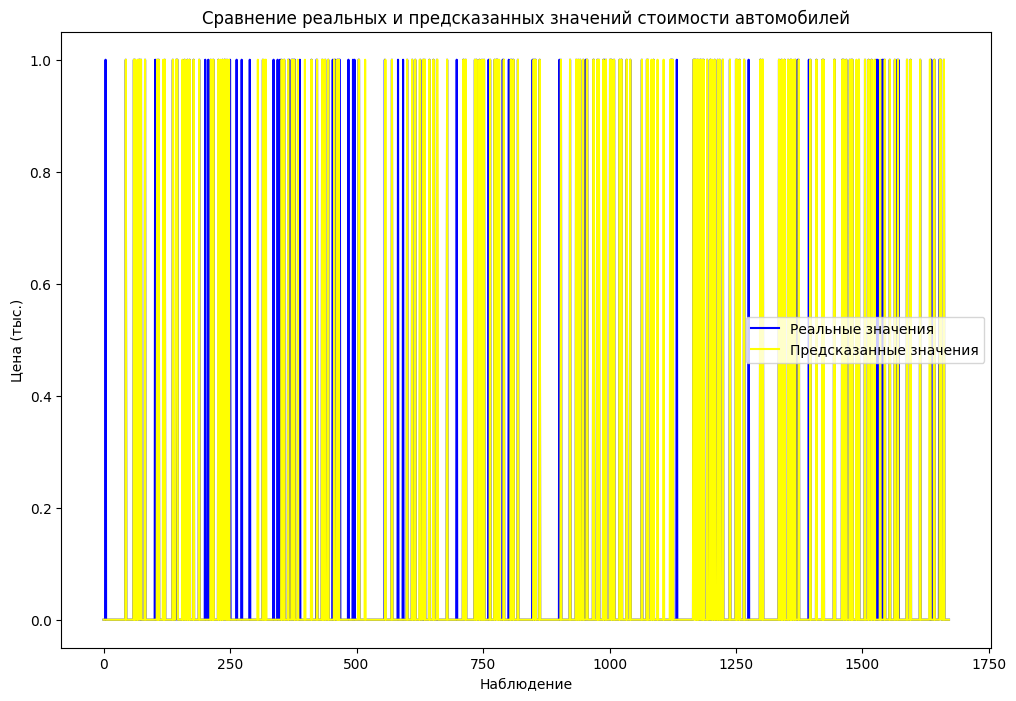

In [25]:
# Сортировка значений для визуализации
results_sorted_log = results_log.sort_index()

# Построение графика
plt.figure(figsize=(12, 8))
plt.plot(results_sorted_log['Real'].values, label='Реальные значения', color='blue')
plt.plot(results_sorted_log['Predicted'].values, label='Предсказанные значения', color='yellow')
plt.legend()
plt.title('Сравнение реальных и предсказанных значений стоимости автомобилей')
plt.xlabel('Наблюдение')
plt.ylabel('Цена (тыс.)')
plt.show()

,Real,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,1,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


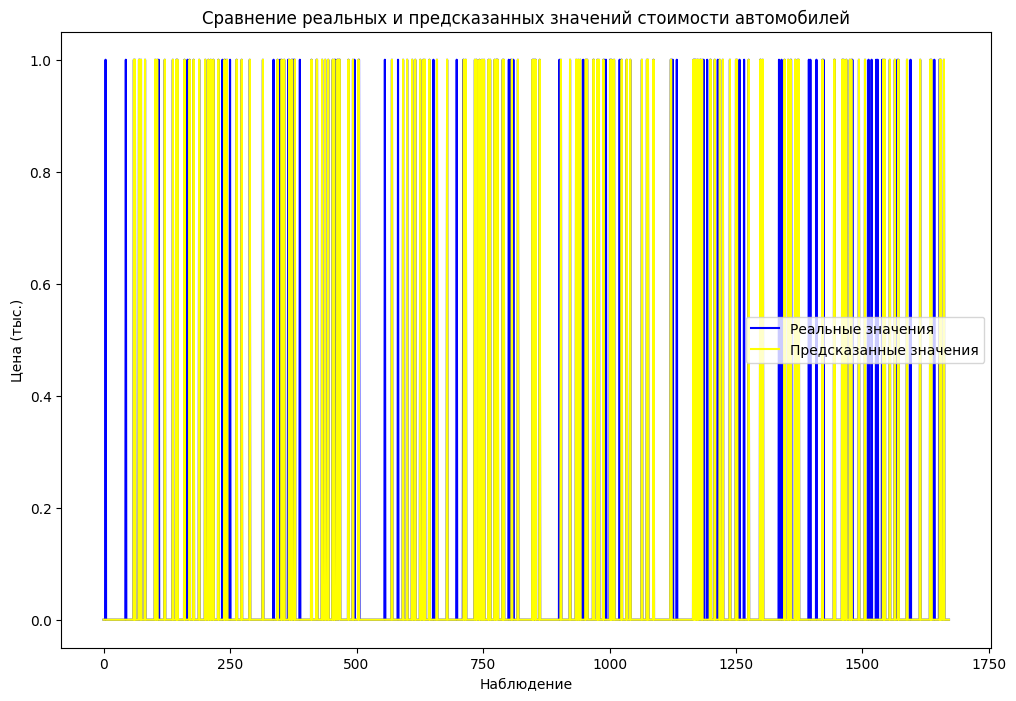

In [27]:
results_nb = pd.DataFrame({
    'Real': y_test_nb,
    'Predicted': y_pred_nb
})

display(results_nb.head(10))

results_sorted_nb = results_nb.sort_index()
plt.figure(figsize=(12, 8))
plt.plot(results_sorted_nb['Real'].values, label='Реальные значения', color='blue')
plt.plot(results_sorted_nb['Predicted'].values, label='Предсказанные значения', color='yellow')
plt.legend()
plt.title('Сравнение реальных и предсказанных значений стоимости автомобилей')
plt.xlabel('Наблюдение')
plt.ylabel('Цена (тыс.)')
plt.show()